In [1]:
using ForwardDiff
using Plots

In [2]:
## Double Pendulum (from iLQR paper)
n = 4
m = 2

# initial and goal states
x0 = [0.;0.;0.;0.]
xf = [pi;0.;0.;0.]

# costs
Q = 1e-5*eye(n)
Qf = 25.*eye(n)
R = 1e-5*eye(m)

# simulation
tf = 1.
dt = 0.1

0.1

In [3]:
function fc(x,u)
    m1 = 1.4
    m2 = 1
    l1 = 0.3
    l2 = 0.33
    s1 = 0.11
    s2 = 0.16
    I1 = 0.025
    I2 = 0.045
    
    a1 = I1 + I2 + m2*l1^2
    a2 = m2*l1*s2
    a3 = I2
    M = [(a1 + 2*a2*cos(x[2])) (a3 + a2*cos(x[2])); (a3 + a2*cos(x[2])) a3]
    C = [-x[4]*(2*x[3] + x[4]); x[3]^2]*a2*sin(x[2])
    B = [0.05 0.025; 0.025 0.05]
    
    F = -M\(C + B*x[3:4])
    
    xd = F + M\u
    return [x[3]; x[4]; xd[1]; xd[2]]
end

function f(x,u,dt)
    return x + fc(x + fc(x,u)*dt/2,u)*dt
end

function fc2(x)
    m1 = 1.4
    m2 = 1
    l1 = 0.3
    l2 = 0.33
    s1 = 0.11
    s2 = 0.16
    I1 = 0.025
    I2 = 0.045
    
    a1 = I1 + I2 + m2*l1^2
    a2 = m2*l1*s2
    a3 = I2
    M = [(a1 + 2*a2*cos(x[2])) (a3 + a2*cos(x[2])); (a3 + a2*cos(x[2])) a3]
    C = [-x[4]*(2*x[3] + x[4]); x[3]^2]*a2*sin(x[2])
    B = [0.05 0.025; 0.025 0.05]
    
    F = -M\(C + B*x[3:4])
    
    xd = F + M\x[5:6]
    return [x[3];x[4];xd[1];xd[2];0.;0.;0.]
end


function f2(x)
    return x + fc2(x + fc2(x)*x[7]/2)*x[7]
end

Df = x-> ForwardDiff.jacobian(f2,x)

(::#3) (generic function with 1 method)

In [6]:
x = ones(7)
Df(x)

7×7 Array{Float64,2}:
 1.0    5.37079   1.98711   1.07632     4.99733    -7.87741    -2.48072
 0.0   -9.31635  -2.73134  -1.25218    -7.87741    23.5284     26.1447 
 0.0  -53.6088   -8.14783  -0.828206  -25.3425    166.088     192.841  
 0.0  150.757    14.8996   42.4612     41.1042   -190.574    -178.084  
 0.0    0.0       0.0       0.0         1.0         0.0         0.0    
 0.0    0.0       0.0       0.0         0.0         1.0         0.0    
 0.0    0.0       0.0       0.0         0.0         0.0         1.0    

In [112]:
#iLQR
function rollout(x0,U,f,dt,tf)
    N = convert(Int64,floor(tf/dt))
    X = zeros(size(x0,1),N)
    X[:,1] = x0
    for k = 1:N-1
      X[:,k+1] = f(X[:,k],U[:,k],dt)
    end
    return X
end

function cost(X,U,Q,R,Qf,xf)
    N = size(X,2)
    J = 0.
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(X,U,Df,Q,R,Qf,xf)
    n, N = size(X)
    m = size(U,1)
    S = zeros(n,n,N)
    s = zeros(n,N)
    K = zeros(m,n,N)
    l = zeros(m,N)
    C1 = zeros(1,n,N)
    C2 = zeros(1,m,N)
    C3 = zeros(n,n,N)
    C4 = zeros(m,m,N)
    C5 = zeros(m,n,N)
    S[:,:,N] = Qf
    s[:,N] = Qf*(X[:,N] - xf)

    mu = 0.
    k = N-1
    while k >= 1
        q = Q*(X[:,k] - xf)
        r = R*(U[:,k])
        Df_aug = Df([X[:,k];U[:,k];dt])
        A = Df_aug[1:size(X,1),1:size(X,1)]
        B = Df_aug[1:size(X,1),size(X,1)+1:size(X,1)+size(U,1)]
        C1[:,:,k] = q' + s[:,k+1]'*A
        C2[:,:,k] = r' + s[:,k+1]'*B
        C3[:,:,k] = Q + A'*S[:,:,k+1]*A
        C4[:,:,k] = R + B'*(S[:,:,k+1] + mu*eye(n))*B
        C5[:,:,k] = B'*(S[:,:,k+1] + mu*eye(n))*A

        # regularization
        if any(x->x < 0, eigvals(C4[:,:,k]))
            mu_reg = mu_reg + 1;
            k = N-1;
        end

        K[:,:,k] = C4[:,:,k]\C5[:,:,k]
        l[:,k] = C4[:,:,k]\C2[:,:,k]'
        s[:,k] = C1[:,:,k] - C2[:,:,k]*K[:,:,k] + l[:,k]'*C4[:,:,k]*K[:,:,k] - l[:,k]'*C5[:,:,k]
        S[:,:,k] = C3[:,:,k] + K[:,:,k]'*C4[:,:,k]*K[:,:,k] - K[:,:,k]'*C5[:,:,k] - C5[:,:,k]'*K[:,:,k]

        k = k - 1;
    end
    return K, l, S, s
end

function forwardpass(x0,U,f,Q,R,Qf,xf,dt,tf)
    X = rollout(x0,U,f,dt,tf)
    J = cost(X,U,Q,R,Qf,xf)
    return X, J
end

function solve(x0,m,f,Df,Q,R,Qf,xf,dt,tf,iterations=100,eps=1e-5)
    N = convert(Int64,floor(tf/dt))
    U = zeros(m,N-1)
    X = zeros(size(x0,1),N)
    X, J = forwardpass(x0,U,f,Q,R,Qf,xf,dt,tf)
    println("Initial Cost: $J")
    
    for i = 1:iterations
      K, l, S, s = backwardpass(X,U,Df,Q,R,Qf,xf)
      X_prev = copy(X)
      J_prev = copy(J)
      U_ = zeros(m,N-1)
      J = Inf
      alpha = 1
      while J > J_prev
          X[:,1] = x0
          for k = 1:N-1
              U_[:,k] = U[:,k] - K[:,:,k]*(X[:,k] - X_prev[:,k]) - alpha*l[:,k]
              X[:,k+1] = f(X[:,k],U_[:,k],dt);
          end

          J = cost(X,U_,Q,R,Qf,xf)
          alpha = alpha/2;
      end

      U = copy(U_);
      println("New cost: $J")

      if abs(J - J_prev) < eps
          println("eps criteria met at iteration: $i")
          break
      end

    end
    
    return X, U
end

solve (generic function with 3 methods)

Initial Cost: 123.37049914581503
New cost: 0.0026751780778625674
New cost: 0.001455057353319292
New cost: 0.0014541958743178247
eps criteria met at iteration: 3
  1.110456 seconds (509.32 k allocations: 21.156 MiB, 13.67% gc time)


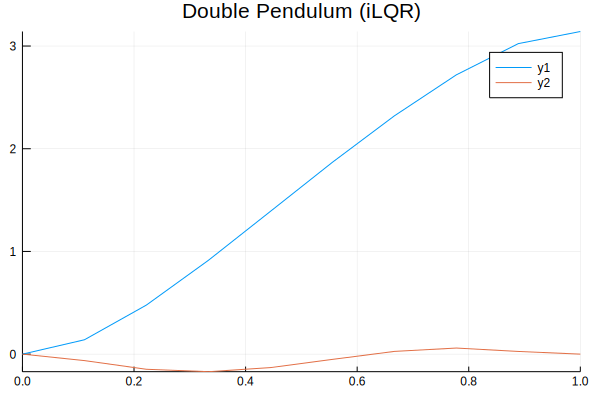

In [113]:
X, U = @time solve(x0,m,f,Df,Q,R,Qf,xf,dt,tf)

P = plot(linspace(0,tf,size(X,2)),X[1,:],title="Double Pendulum (iLQR)")
P = plot!(linspace(0,tf,size(X,2)),X[2,:])

In [116]:
function Transform(theta,alpha,d,a)
    T = [cos(theta) -sin(theta) 0 a;
         sin(theta)*cos(alpha) cos(theta)*cos(alpha) -sin(alpha) -sin(alpha)*d;
         sin(theta)*sin(alpha) cos(theta)*sin(alpha) cos(alpha) cos(alpha)*d;
         0 0 0 1];
    return T
end


plt = plot()
@gif for i=1:size(X,2)
    l1 = 0.33
    l2 = 0.3
    theta1 = X[1,i] -pi/2
    theta2 = X[2,i]
    x1 = l1*cos(theta1)
    y1 = l1*sin(theta1)
    x2 = x1 + l2*cos(theta1+theta2)
    y2 = y1 + l2*sin(theta1+theta2)
    
            
    plt = plot([0,x1],[0,y1],xlims=(-1.,1.),ylims=(-1.,1.),color="green",size=(200,200),label="")
    plt = plot!([x1,x2],[y1,y2],color="red",label="")
end 

INFO: Saved animation to C:\Users\taylor howell\Google Drive\Stanford\Research-Manchester\iLQR Julia\tmp.gif


Plots.AnimatedGif("C:\\Users\\taylor howell\\Google Drive\\Stanford\\Research-Manchester\\iLQR Julia\\tmp.gif")